In [4]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor
import pymannkendall as mk

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [5]:
# read processed data from pkl file
pkl_file = open('NH_winter_temp_anom.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)

# recover the original values by adding the climatology
with xr.open_dataset(path_ + pre_ + '1980.nc') as ds:
    climatology = ds.climatology.values[:,-90:,:]

doy_l = [0, 31, 59, 304, 334]
doy_r = [31, 59, 90, 334, 365]
ll = [0, 31, 59, 90, 120, 151]
for yy in range(40):
    for mm in range(5):
        il, ir = 151*yy + ll[mm], 151*yy + ll[mm+1]
        temp[il:ir,:,:] += climatology[doy_l[mm]:doy_r[mm],:,:]

temp = temp[90:-61,:,:]

In [6]:
temp_climatology = np.mean(temp, axis=0)
temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp, axis=0))
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [ ]:
# compute median and mean trends and p-values

xx = np.arange(39)
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

cnt = 0
t1 = time() 
k_mean = []
k_median = []
climatology_v = []

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        k_mean.append(lm1.coef_[0] * 10)

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        k_median.append(lm2.coef_[0] * 10)

        climatology_v.append(temp_climatology[i, j])

k_mean = np.array(k_mean)
k_median = np.array(k_median)
climatology_v = np.array(climatology_v)
        

In [ ]:

# Define the bins and corresponding labels
bins = [-30, -20, -10, 0, 10]
# bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(climatology_v, bins)

k_mean_group = {}
k_median_group = {}
diff_group = {}
climatology_group = {}

for i in range(len(bins)+1):
    k_mean_group[i] = []
    k_median_group[i] = []
    diff_group[i] = []
    climatology_group[i] = []

cnt = 0
for idx, group_id in enumerate(grouped_indices):
    k_mean_group[group_id].append(k_mean[idx])
    k_median_group[group_id].append(k_median[idx])
    diff_group[group_id].append(k_median[idx] - k_mean[idx])
    climatology_group[group_id].append(climatology_v[idx])
    if k_median[idx] - k_mean[idx] > 0:
        cnt += 1

mid_mean = []
upp_mean = []
low_mean = []
for i in range(len(bins)+1):
    mid_mean.append(np.median(k_mean_group[i]))
    upp_mean.append(np.percentile(k_mean_group[i], 75))
    low_mean.append(np.percentile(k_mean_group[i], 25))

mid_median = []
upp_median = []
low_median = []
for i in range(len(bins)+1):
    mid_median.append(np.median(k_median_group[i]))
    upp_median.append(np.percentile(k_median_group[i], 75))
    low_median.append(np.percentile(k_median_group[i], 25))

mid_diff = []
upp_diff = []
low_diff = []
for i in range(len(bins)+1):
    mid_diff.append(np.median(diff_group[i]))
    upp_diff.append(np.percentile(diff_group[i], 25))
    low_diff.append(np.percentile(diff_group[i], 75))

fig, ax = plt.subplots(3, 1, figsize=(5, 9))
ax[0].plot(np.arange(len(bins)+1), mid_mean, label='Mean')
ax[0].fill_between(np.arange(len(bins)+1), low_mean, upp_mean, alpha=0.2)
ax[0].plot(np.arange(len(bins)+1), mid_median, label='Median')
ax[0].fill_between(np.arange(len(bins)+1), low_median, upp_median, alpha=0.2)
ax[0].set_xticks(np.arange(len(bins)+1))
ax[0].set_xticklabels(label_str)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_ylabel('Trend [°C/decade]')

ax[1].plot(np.arange(len(bins)+1), mid_diff, label='Median - Mean')
ax[1].fill_between(np.arange(len(bins)+1), low_diff, upp_diff, alpha=0.2)
ax[1].axline((0, 0), slope=0, color='black', linestyle='--')
ax[1].set_xticks(np.arange(len(bins)+1))
ax[1].set_xticklabels(label_str)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].legend()
ax[1].set_ylabel('Trend Diff [°C/decade]')

ax[2].scatter(climatology_v, k_median - k_mean, color='blue', marker='.', s=1)
ax[2].axline((0, 0), slope=0, color='black', linestyle='--')
ax[2].set_ylabel('Trend Diff [°C/decade]')
ax[2].set_xlabel('Climatology [°C]')

fig.tight_layout()
fig.savefig('figures/trends_grouped_by_climatology_whole_NH.png')


In [ ]:
k = 6
neg_cnt = sum([x < 0 for x in diff_group[k]])
print(neg_cnt / len(diff_group[k]))

In [22]:
# compute median and mean trends and p-values
xx = np.arange(39)
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

temp_climatology = np.mean(temp, axis=0)

cnt = 0
t1 = time() 
comp_gridded = []
comp_insitu = []

for i in range(90):
    for j in range(360):
        if not mask[i, j]: continue
        if swe_gridded[i,j] > 4: continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        
        comp_gridded.append((temp_climatology[i,j], lm1.coef_[0] * 10, lm2.coef_[0] * 10, swe_gridded[i,j]))
        if swe_insitu[i,j] != 0:
            comp_insitu.append((temp_climatology[i,j], lm1.coef_[0] * 10, lm2.coef_[0] * 10, swe_insitu[i,j]))

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)

Processing  1000  grids. Time taken so far:  18.30637788772583
Processing  2000  grids. Time taken so far:  37.429969787597656
Processing  3000  grids. Time taken so far:  57.168219566345215
Processing  4000  grids. Time taken so far:  76.78688907623291
Processing  5000  grids. Time taken so far:  96.55979800224304
Processing  6000  grids. Time taken so far:  116.86421966552734
Processing  7000  grids. Time taken so far:  138.03249335289001


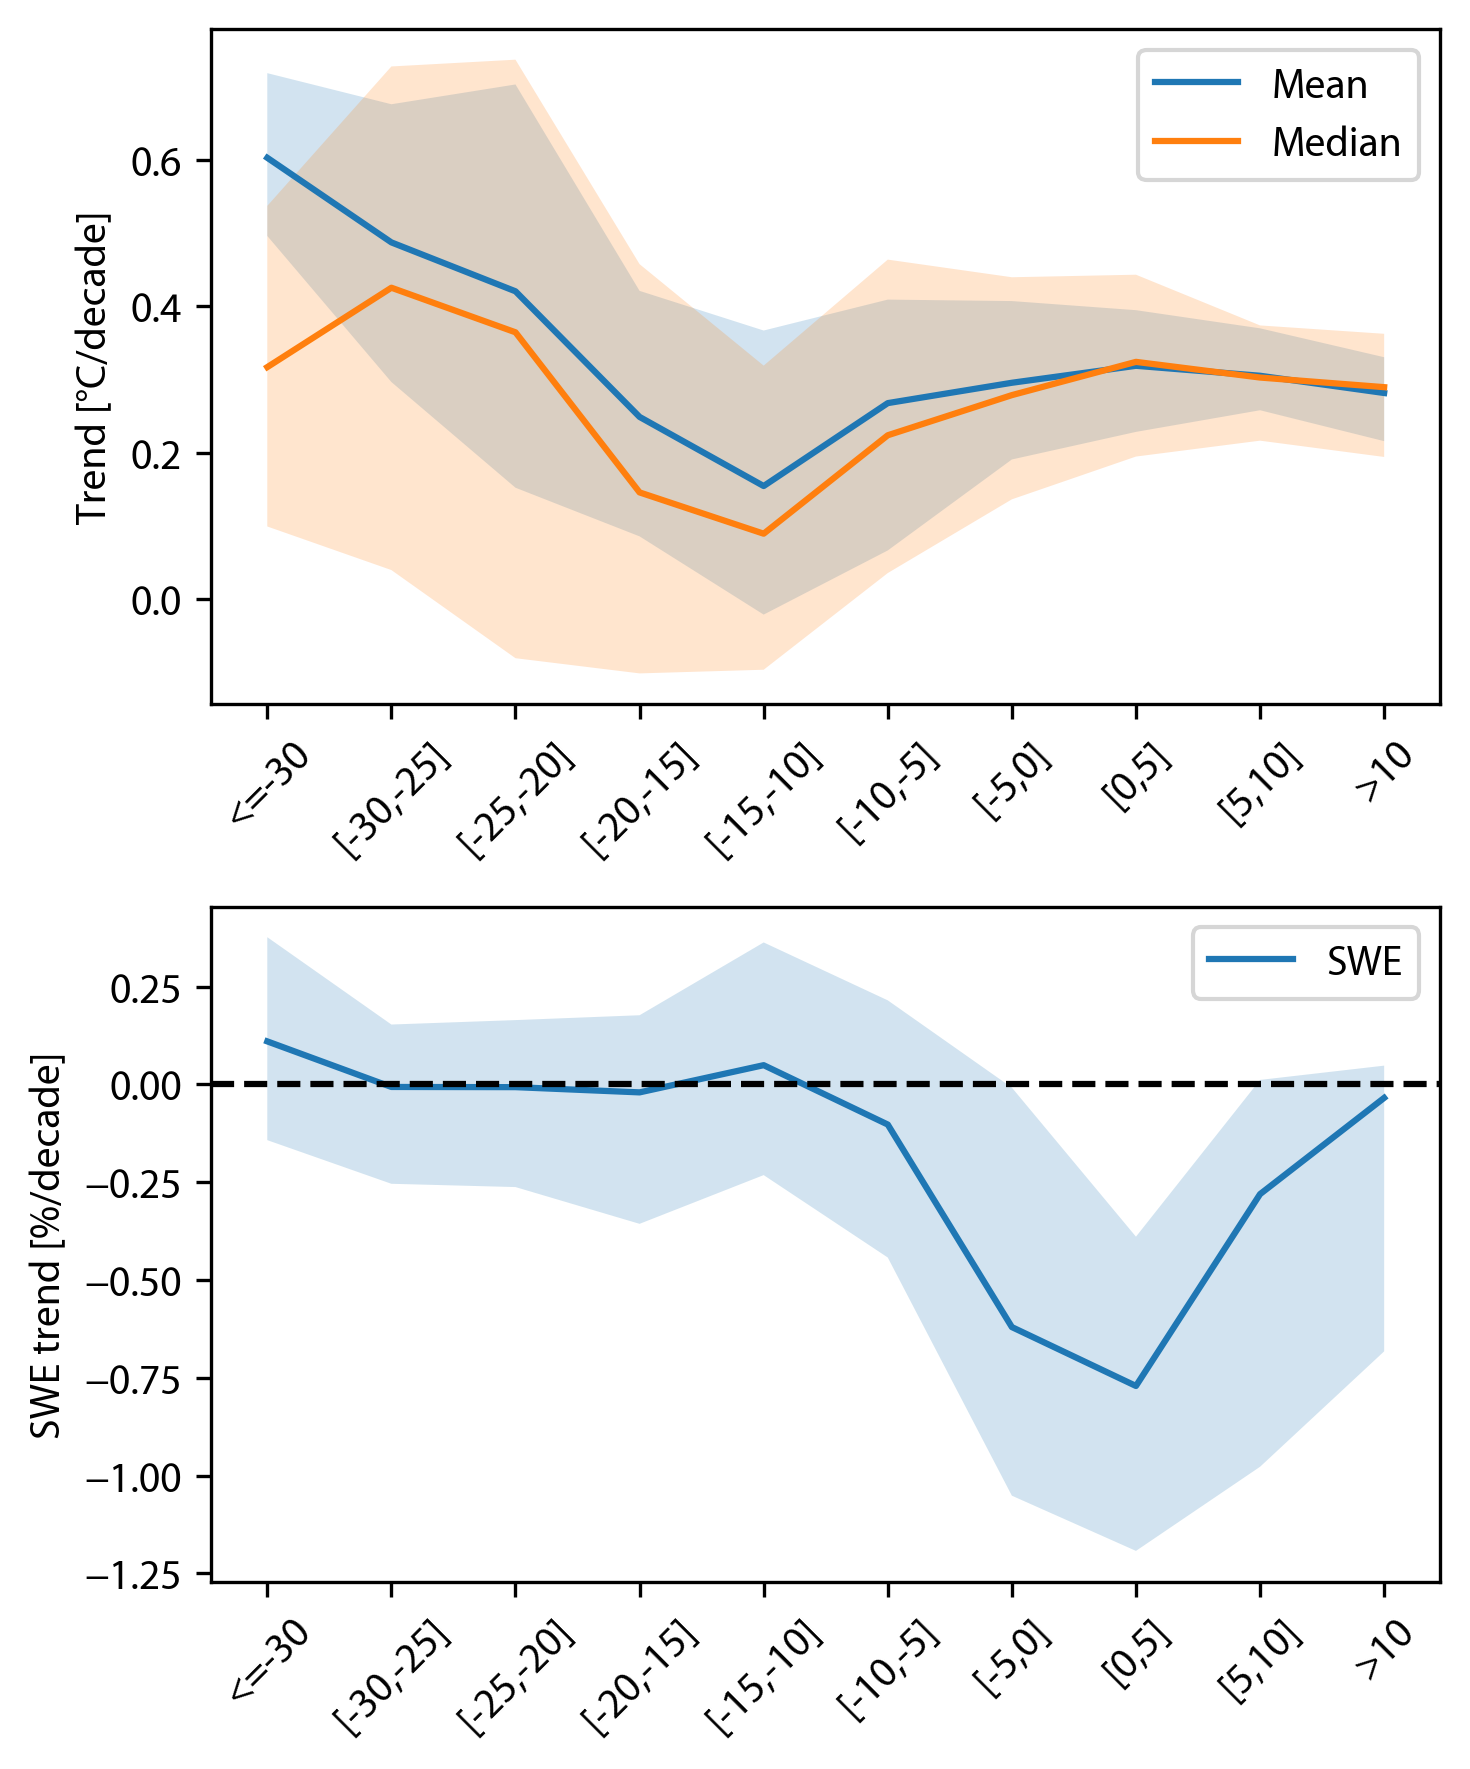

In [23]:
bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(comp_gridded[:,0], bins)

k_mean = {}
k_median = {}
swe = {}

for i in range(len(bins)+1):
    k_mean[i] = []
    k_median[i] = []
    swe[i] = []

for idx, group_id in enumerate(grouped_indices):
    k_mean[group_id].append(comp_gridded[idx,1])
    k_median[group_id].append(comp_gridded[idx,2])
    swe[group_id].append(comp_gridded[idx,3])


mid_ = np.zeros((len(bins)+1,3))
upp_ = np.zeros((len(bins)+1,3))
low_ = np.zeros((len(bins)+1,3))
for i in range(len(bins)+1):

    mid_[i,0] = np.median(k_mean[i])
    upp_[i,0] = np.percentile(k_mean[i], 75)
    low_[i,0] = np.percentile(k_mean[i], 25)

    mid_[i,1] = np.median(k_median[i])
    upp_[i,1] = np.percentile(k_median[i], 75)
    low_[i,1] = np.percentile(k_median[i], 25)

    mid_[i,2] = np.median(swe[i])
    upp_[i,2] = np.percentile(swe[i], 75)
    low_[i,2] = np.percentile(swe[i], 25)

fig, ax = plt.subplots(2, 1, figsize=(5, 6))
ax[0].plot(np.arange(len(bins)+1), mid_[:,0], label='Mean')
ax[0].fill_between(np.arange(len(bins)+1), low_[:,0], upp_[:,0], alpha=0.2)
ax[0].plot(np.arange(len(bins)+1), mid_[:,1], label='Median')
ax[0].fill_between(np.arange(len(bins)+1), low_[:,1], upp_[:,1], alpha=0.2)
ax[0].set_xticks(np.arange(len(bins)+1))
ax[0].set_xticklabels(label_str)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_ylabel('Trend [°C/decade]')

ax[1].plot(np.arange(len(bins)+1), mid_[:,2], label='SWE')
ax[1].fill_between(np.arange(len(bins)+1), low_[:,2], upp_[:,2], alpha=0.2)
ax[1].set_xticks(np.arange(len(bins)+1))
ax[1].set_xticklabels(label_str)
ax[1].set_ylabel('SWE trend [%/decade]')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].axline((0, 0), slope=0, color='black', linestyle='--')
ax[1].legend()

fig.tight_layout()


